# Hardware and Software Setup

## Chromatic Tuner

First we need a chromatic tuner that can tell us whether we are any close to our target frequency when we are tuning our piano. Here are some that I suggest for Linux:

### `kguitune`

http://www.oocities.org/harpin_floh/kguitune_page.html

Available as a binary as

```
sudo apt-get install gtkguitune
```

### `lingot`

http://www.nongnu.org/lingot/

Available as a binary as

```
sudo apt-get install lingot
```

## Recording Program

We'll try to do all our recording programmatically in Julia, but it may come handy to have an external software for troubleshooting when setting up the hardware. I recommend the following software in Linux:

#### `Kwave`

Available as a binary as

```
sudo apt-get install kwave
```

#### `Audacity`

Available as a binary as

```
sudo apt-get install audacity
```

## Julia Audio Processing

* Julia has a family of packages for audio processing here: https://github.com/JuliaAudio . 

* This package for handling WAV files may also come handy: https://github.com/dancasimiro/wav.jl

* Here are neat examples of audio processing: https://nbviewer.jupyter.org/github/JuliaAudio/JuliaAudioExamples/blob/master/MP3%20Encoding%20Loss.ipynb

In [4]:
using SampledSignals
using LibSndFile
using FileIO
using PlotlyJS

### Playing 

In [5]:
snd = load("audio/test00.wav")

301954-frame, 2-channel SampleBuf{FixedPointNumbers.Fixed{Int16,15}, 2}
6.84702947845805s sampled at 44100.0Hz
▄▄▄▄▃▃▃▄▅▄▄▄▄▃▇██▇▇▆▇▇▆▇▇▇▆▇▇▆▆▆▆▆▆▆▆▅▄▄▄▄▃▄▃▃▃▄▄▃▃▄▄▄▄▃▃▃▄▄▄▃▃▃▃▃▃▄▃▄▃▄▄▄▃▃▄▃▄▄
▄▄▄▄▃▃▃▄▅▄▄▄▄▃▇██▇▇▆▇▇▆▇▇▇▆▇▇▆▆▆▆▆▆▆▆▅▄▄▄▄▃▄▃▃▃▄▄▃▃▄▄▄▄▃▃▃▄▄▄▃▃▃▃▃▃▄▃▄▃▄▄▄▃▃▄▃▄▄

### Device Recording Through [`PortAudio.jl`](https://github.com/JuliaAudio/PortAudio.jl)

Somehow the master branch of `PortAudio.jl` was left behind in the Julia development. In order to install add the package, you'll need to indicate the v1.0-compatible branch manually:

```julia
(v1.0) pkg> add PortAudio#julia1
```

At first I was encountering the following error:
```julia
julia> microph = "default"
"default"

julia> stream = PortAudioStream(microph, microph)
julia: symbol lookup error: /home/edo/.julia/packages/PortAudio/VaI1c/src/../deps/usr/lib/pa_shim_x86_64-linux-gnu.so: undefined symbol: PaUtil_GetRingBufferWriteAvailable

```

I was able to solve it installing `RingBuffers` in the following sequence:
```julia
(v1.0) pkg> add RingBuffers#master
(v1.0) pkg> build RingBuffers
(v1.0) pkg> build PortAudio
```

In [1]:
using PortAudio, SampledSignals, LibSndFile, FileIO

ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:867:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:867:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:867:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:867:(find_matching_chmap) Found no matching channel map
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock


In [2]:
PortAudio.devices()

13-element Array{PortAudio.PortAudioDevice,1}:
 PortAudio.PortAudioDevice("HDA Intel PCH: ALC3227 Analog (hw:0,0)", "ALSA", 2, 2, 44100.0, 0)
 PortAudio.PortAudioDevice("HDA Intel PCH: HDMI 0 (hw:0,3)", "ALSA", 0, 8, 44100.0, 1)        
 PortAudio.PortAudioDevice("Yeti Nano: USB Audio (hw:1,0)", "ALSA", 2, 2, 44100.0, 2)         
 PortAudio.PortAudioDevice("sysdefault", "ALSA", 128, 128, 48000.0, 3)                        
 PortAudio.PortAudioDevice("front", "ALSA", 0, 2, 44100.0, 4)                                 
 PortAudio.PortAudioDevice("surround40", "ALSA", 0, 2, 44100.0, 5)                            
 PortAudio.PortAudioDevice("surround51", "ALSA", 0, 2, 44100.0, 6)                            
 PortAudio.PortAudioDevice("surround71", "ALSA", 0, 2, 44100.0, 7)                            
 PortAudio.PortAudioDevice("hdmi", "ALSA", 0, 8, 44100.0, 8)                                  
 PortAudio.PortAudioDevice("pulse", "ALSA", 32, 32, 44100.0, 9)                               
 Po

In [2]:
# Grab the Yeti Nano as the input device (microphone)
microph = PortAudio.devices()[3]

PortAudio.PortAudioDevice("Yeti Nano: USB Audio (hw:1,0)", "ALSA", 2, 2, 44100.0, 2)

In [3]:
? PortAudioStream

search: PortAudioStream



```
PortAudioStream(inchannels=2, outchannels=2; options...)
PortAudioStream(duplexdevice, inchannels=2, outchannels=2; options...)
PortAudioStream(indevice, outdevice, inchannels=2, outchannels=2; options...)
```

Audio devices can either be `PortAudioDevice` instances as returned by `PortAudio.devices()`, or strings with the device name as reported by the operating system. If a single `duplexdevice` is given it will be used for both input and output. If no devices are given the system default devices will be used.

Options:

  * `eltype`:       Sample type of the audio stream (defaults to Float32)
  * `samplerate`:   Sample rate (defaults to device sample rate)
  * `blocksize`:    Size of the blocks that are written to and read from the audio                 device. (Defaults to 4096)
  * `synced`:       Determines whether the input and output streams are kept in                 sync. If `true`, you must read and write an equal number of                 frames, and the round-trip latency is guaranteed constant. If                 `false`, you are free to read and write separately, but                 overflow or underflow can affect the round-trip latency.
  * `warn_xruns`:   Display a warning if there is a stream overrun or underrun,                 which often happens when Julia is compiling, or with a                 particularly large GC run. This can be quite verbose so is                 false by default.


In [4]:
# Open the microphone stream
stream = PortAudioStream(microph, 2, 0)

PortAudioStream{Float32}
  Samplerate: 44100.0Hz
  Buffer Size: 4096 frames
  2 channel source: "Yeti Nano: USB Audio (hw:1,0)"

In [17]:
propertynames(stream)

(:samplerate, :blocksize, :stream, :warn_xruns, :sink, :source, :errbuf, :errtask, :bufinfo)

In [18]:
stream.samplerate

44100.0

In [29]:
s = 3
samples = ceil(Int, s*stream.samplerate)

# Record 10 seconds of the stream
buf = read(stream, samples)

132300-frame, 2-channel SampleBuf{Float32, 2}
3.0s sampled at 44100.0Hz
▂▂▂▂▂▄▃▂▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▃▅▅▅▅▅▇▆▅▅▅▅▅▄▄▅▅▅▅▆▅▅▅▄▅▄▅▄▃▃▄▄▄▄▄▄▃▃▃▄▅▂▂▂▂▂▂▂▅█▄▄▃
▂▂▂▂▂▄▃▂▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▃▅▅▅▅▅▇▆▅▅▅▅▅▄▄▅▅▅▅▆▅▅▅▄▅▄▅▄▃▃▄▄▄▄▄▄▃▃▃▄▅▂▂▂▂▂▂▂▅█▄▄▃

In [36]:
save("audio/test01.wav", buf)

In [37]:
snd = load("audio/test01.wav")

132300-frame, 2-channel SampleBuf{Float32, 2}
3.0s sampled at 44100.0Hz
▂▂▂▂▂▄▃▂▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▃▅▅▅▅▅▇▆▅▅▅▅▅▄▄▅▅▅▅▆▅▅▅▄▅▄▅▄▃▃▄▄▄▄▄▄▃▃▃▄▅▂▂▂▂▂▂▂▅█▄▄▃
▂▂▂▂▂▄▃▂▂▃▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▂▃▅▅▅▅▅▇▆▅▅▅▅▅▄▄▅▅▅▅▆▅▅▅▄▅▄▅▄▃▃▄▄▄▄▄▄▃▃▃▄▅▂▂▂▂▂▂▂▅█▄▄▃

# Sound Processing

## Frequency Identification Through Fourier Transform

* https://stackoverflow.com/questions/4364823/how-do-i-obtain-the-frequencies-of-each-value-in-an-fft
* https://www.mathworks.com/help/matlab/ref/fft.html#buuutyt-6
* https://juliamath.github.io/AbstractFFTs.jl/stable/api/#Public-Interface-1

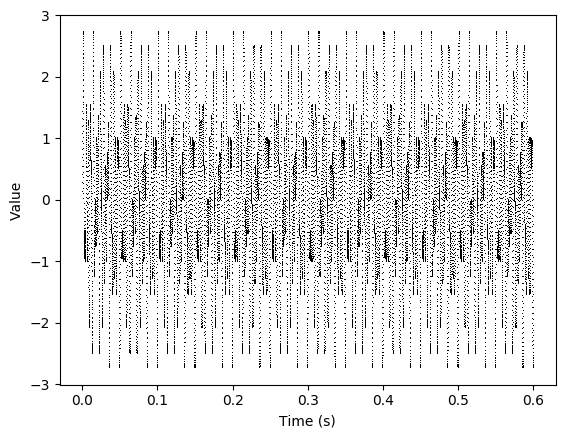

PyObject Text(24,0.5,'Value')

In [155]:
# Artificial data
freqs = [220, 440, 300][1:end]   # hz

samplerate = 44100        # samples/sec
tend = 6.0e-1                # (s) end of sampling
nsamples = tend*samplerate
dt = 1/samplerate

ts = dt*(1:nsamples)
data = zeros(size(ts))

for (i, t) in enumerate(ts)
    for freq in freqs
        data[i] += sin(2*pi*freq*t)
    end
end

plot(ts, data, ",k")
xlabel("Time (s)")
ylabel("Value")

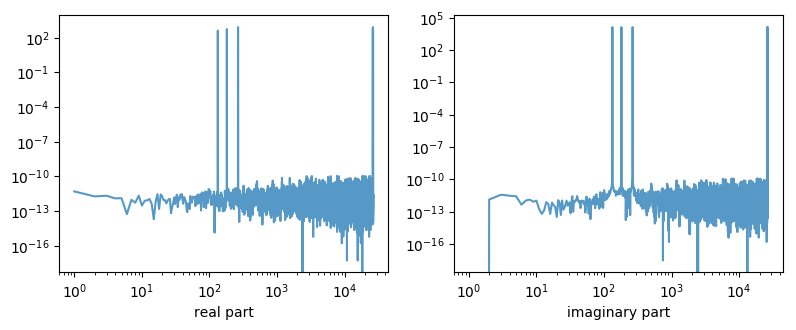

PyObject Text(0.5,24,'imaginary part')

In [156]:
using FFTW
using Statistics
fftdata = fft(data)

figure(figsize=[7*2, 5*1]*2/3)

subplot(121)
plot(1:size(fftdata, 1), [abs(real(d)) for d in fftdata], alpha=0.75)
gca().set_xscale("log")
gca().set_yscale("log")
xlabel("k")
xlabel("real part")

subplot(122)
plot(1:size(fftdata, 1), [abs(imag(d)) for d in fftdata], alpha=0.75)
gca().set_xscale("log")
gca().set_yscale("log")
xlabel("k")
xlabel("imaginary part")

In [159]:
# norms = Statistics.norm.([imag(d) for d in data])
norms = [abs(imag(d)) for d in fftdata]
meannorm = Statistics.mean(norms)
stddev = Statistics.std(norms)

maxinds = [i for (i, norm) in enumerate(norms) if norm>= meannorm + 1e-10*stddev]
maxfreqs = samplerate * (maxinds.-1)/size(fftdata, 1)

6-element Array{Float64,1}:
   220.0
   300.0
   440.0
 43660.0
 43800.0
 43880.0

## Guitar 220 hz

In [1]:
using PortAudio, SampledSignals, LibSndFile, FileIO

ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2495:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
ALSA lib pcm_route.c:867:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:867:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:867:(find_matching_chmap) Found no matching channel map
ALSA lib pcm_route.c:867:(find_matching_chmap) Found no matching channel map
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock


In [2]:
# Grab the Yeti Nano as the input device (microphone)
microph = PortAudio.devices()[3]

PortAudio.PortAudioDevice("Yeti Nano: USB Audio (hw:1,0)", "ALSA", 2, 2, 44100.0, 2)

In [3]:
# Open the microphone stream
stream = PortAudioStream(microph, 2, 0)

PortAudioStream{Float32}
  Samplerate: 44100.0Hz
  Buffer Size: 4096 frames
  2 channel source: "Yeti Nano: USB Audio (hw:1,0)"

In [6]:
s = 3
samples = ceil(Int, s*stream.samplerate)

# Record 10 seconds of the stream
buf = read(stream, samples)

132300-frame, 2-channel SampleBuf{Float32, 2}
3.0s sampled at 44100.0Hz
▄▄▄▄▄▄▃▂▂▆▆▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃
▄▄▄▄▄▄▃▂▂▆▆▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃

In [7]:
save("audio/test220_00.wav", buf)

In [9]:
snd = load("audio/test220_00.wav")

132300-frame, 2-channel SampleBuf{Float32, 2}
3.0s sampled at 44100.0Hz
▄▄▄▄▄▄▃▂▂▆▆▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃
▄▄▄▄▄▄▃▂▂▆▆▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃

In [11]:
fieldnames(typeof(snd))

(:data, :samplerate)

In [12]:
snd.data

132300×2 Array{Float32,2}:
 0.0338649   0.0338649 
 0.0339156   0.0339156 
 0.0339711   0.0339711 
 0.0337815   0.0337815 
 0.0335701   0.0335701 
 0.0332706   0.0332706 
 0.0331126   0.0331126 
 0.0326108   0.0326108 
 0.0323521   0.0323521 
 0.031973    0.031973  
 0.0316746   0.0316746 
 0.0315657   0.0315657 
 0.0314244   0.0314244 
 ⋮                     
 0.00668371  0.00668371
 0.006791    0.006791  
 0.00673532  0.00673532
 0.00672364  0.00672364
 0.00688088  0.00688088
 0.00689912  0.00689912
 0.00693023  0.00693023
 0.00694382  0.00694382
 0.00713432  0.00713432
 0.00722742  0.00722742
 0.00739717  0.00739717
 0.00728881  0.00728881

In [13]:
snd.samplerate

44100.0

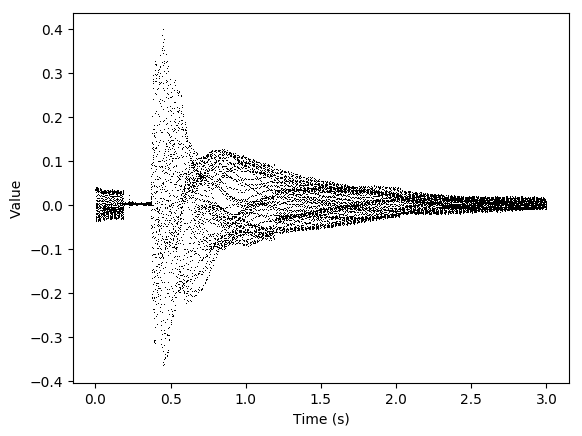

PyObject Text(24,0.5,'Value')

In [160]:
using PyPlot

step = 10
dt = 1/snd.samplerate
plot(dt*(1:step:size(snd.data, 1)), snd.data[1:step:end, 1], ",k")
xlabel("Time (s)")
ylabel("Value")

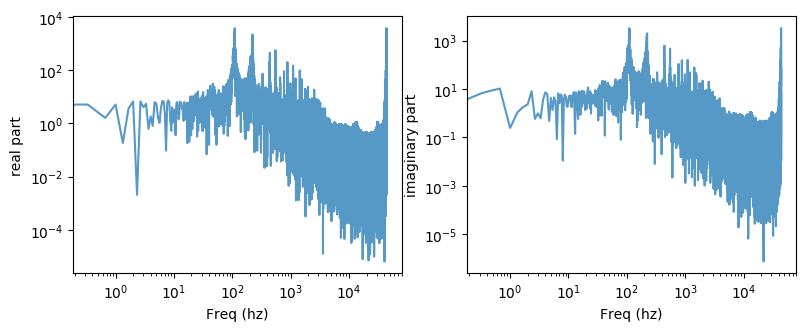

PyObject Text(418.686,0.5,'imaginary part')

In [164]:
using FFTW
using Statistics

fftdata = fft(snd.data)

figure(figsize=[7*2, 5*1]*2/3)

freqs = snd.samplerate * (0:size(fftdata, 1)-1)/size(fftdata, 1)

subplot(121)
plot(freqs, [abs(real(d)) for d in fftdata], alpha=0.75)
gca().set_xscale("log")
gca().set_yscale("log")
xlabel("Freq (hz)")
ylabel("real part")

subplot(122)
plot(freqs, [abs(imag(d)) for d in fftdata], alpha=0.75)
gca().set_xscale("log")
gca().set_yscale("log")
xlabel("Freq (hz)")
ylabel("imaginary part")

In [193]:
norms = [abs(imag(d)) for d in fftdata[1:ceil(Int, size(fftdata, 1)/2)]]
meannorm = Statistics.mean(norms)
stddev = Statistics.std(norms)

maxinds = [i for (i, norm) in enumerate(norms) if norm>= meannorm + 1.0*stddev]
maxfreqs = snd.samplerate * (maxinds.-1)/size(fftdata, 1)

352-element Array{Float64,1}:
   85.66666666666667
   86.66666666666667
   88.33333333333333
   90.0             
   90.66666666666667
   91.0             
   91.66666666666667
   92.66666666666667
   93.33333333333333
   94.0             
   94.33333333333333
   94.66666666666667
   95.0             
    ⋮               
 1102.3333333333333 
 1210.6666666666667 
 1430.6666666666667 
 1431.3333333333333 
 1431.6666666666667 
 1432.0             
 1432.3333333333333 
 1433.3333333333333 
 1541.3333333333333 
 1541.6666666666667 
 1542.0             
 1542.3333333333333 

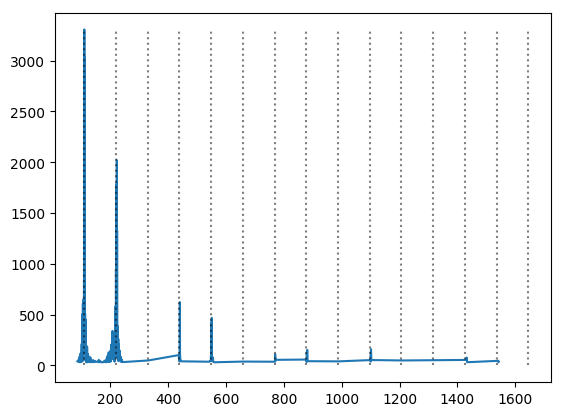

In [198]:
plot(maxfreqs, norms[maxinds])

maxval, maxind = findmax(norms[maxinds])
for i in 1:15
    plot(i*maxfreqs[maxind]*ones(2), [0, maxval], ":k", alpha=0.5)
end

With this criteria, the fundamental frequency is 110 hz. How about we look at the energy of each of this resonant frequency instead of the microphone readout?
This can be done with a rough approximation to the sound intensity given by the frequency times the amplitude:

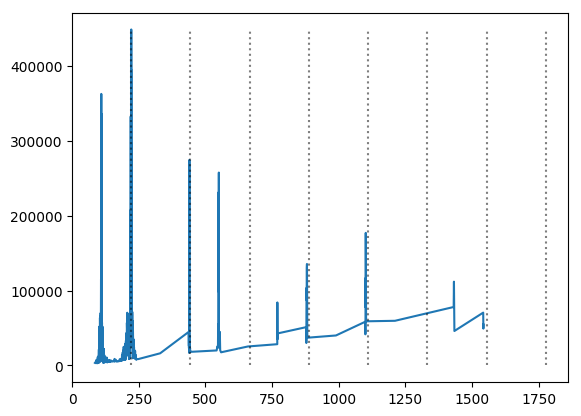

Fundamental frequency: 222.0


In [202]:
plot(maxfreqs, maxfreqs.*norms[maxinds])

maxval, maxind = findmax(maxfreqs.*norms[maxinds])
for i in 1:8
    plot(i*maxfreqs[maxind]*ones(2), [0, maxval], ":k", alpha=0.5)
end
println("Fundamental frequency: $(maxfreqs[maxind])")

That's better =]. We can also notice the appearance of overtones resonating with half the fundamental frequency which is also strong.

## Piano 440 hz

In [2]:
# Grab the Yeti Nano as the input device (microphone)
microph = PortAudio.devices()[3]

PortAudio.PortAudioDevice("Yeti Nano: USB Audio (hw:1,0)", "ALSA", 2, 2, 44100.0, 2)

In [3]:
# Open the microphone stream
stream = PortAudioStream(microph, 2, 0)

PortAudioStream{Float32}
  Samplerate: 44100.0Hz
  Buffer Size: 4096 frames
  2 channel source: "Yeti Nano: USB Audio (hw:1,0)"

In [204]:
s = 3
samples = ceil(Int, s*stream.samplerate)

# Record 10 seconds of the stream
buf = read(stream, samples)

132300-frame, 2-channel SampleBuf{Float32, 2}
3.0s sampled at 44100.0Hz
▃▃▃▃▃▂▂▂▂▂▂▂▂▃▇█▇▇▆▆▆▆▆▆▆▆▆▆▆▅▅▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃
▃▃▃▃▃▂▂▂▂▂▂▂▂▃▇█▇▇▆▆▆▆▆▆▆▆▆▆▆▅▅▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃

In [205]:
save("audio/test440_00.wav", buf)

In [206]:
snd = load("audio/test440_00.wav")

132300-frame, 2-channel SampleBuf{Float32, 2}
3.0s sampled at 44100.0Hz
▃▃▃▃▃▂▂▂▂▂▂▂▂▃▇█▇▇▆▆▆▆▆▆▆▆▆▆▆▅▅▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃
▃▃▃▃▃▂▂▂▂▂▂▂▂▃▇█▇▇▆▆▆▆▆▆▆▆▆▆▆▅▅▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▅▅▅▅▄▄▄▄▄▄▄▄▄▄▃▃▃▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃

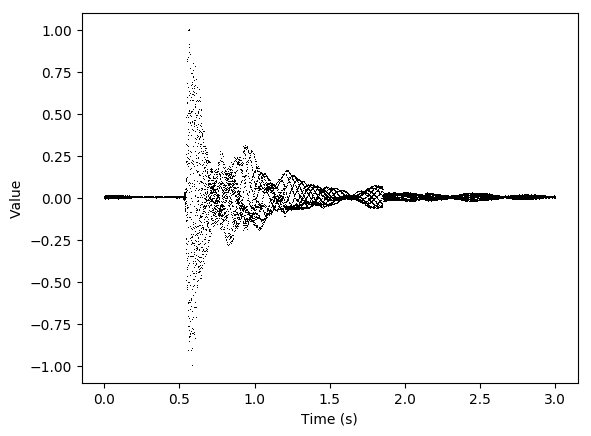

PyObject Text(24,0.5,'Value')

In [207]:
using PyPlot

step = 10
dt = 1/snd.samplerate
plot(dt*(1:step:size(snd.data, 1)), snd.data[1:step:end, 1], ",k")
xlabel("Time (s)")
ylabel("Value")

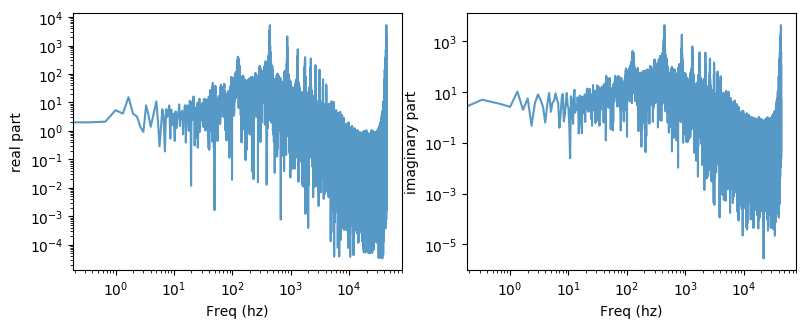

PyObject Text(418.686,0.5,'imaginary part')

In [208]:
using FFTW
using Statistics

fftdata = fft(snd.data)

figure(figsize=[7*2, 5*1]*2/3)

freqs = snd.samplerate * (0:size(fftdata, 1)-1)/size(fftdata, 1)

subplot(121)
plot(freqs, [abs(real(d)) for d in fftdata], alpha=0.75)
gca().set_xscale("log")
gca().set_yscale("log")
xlabel("Freq (hz)")
ylabel("real part")

subplot(122)
plot(freqs, [abs(imag(d)) for d in fftdata], alpha=0.75)
gca().set_xscale("log")
gca().set_yscale("log")
xlabel("Freq (hz)")
ylabel("imaginary part")

In [209]:
norms = [abs(imag(d)) for d in fftdata[1:ceil(Int, size(fftdata, 1)/2)]]
meannorm = Statistics.mean(norms)
stddev = Statistics.std(norms)

maxinds = [i for (i, norm) in enumerate(norms) if norm>= meannorm + 1.0*stddev]
maxfreqs = snd.samplerate * (maxinds.-1)/size(fftdata, 1)

1196-element Array{Float64,1}:
   96.0             
   96.66666666666667
   97.33333333333333
   98.0             
   98.33333333333333
   99.0             
   99.66666666666667
  104.33333333333333
  107.66666666666667
  108.33333333333333
  110.0             
  111.0             
  111.66666666666667
    ⋮               
 3126.3333333333335 
 3126.6666666666665 
 3127.0             
 3127.6666666666665 
 3128.0             
 3128.6666666666665 
 3129.0             
 3129.3333333333335 
 3129.6666666666665 
 3130.3333333333335 
 3590.0             
 3590.6666666666665 

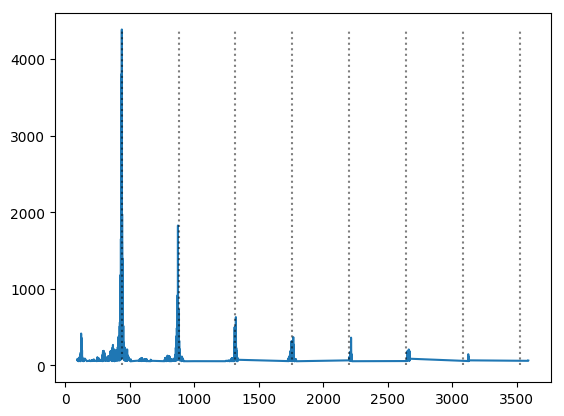

In [211]:
plot(maxfreqs, norms[maxinds])

maxval, maxind = findmax(norms[maxinds])
for i in 1:8
    plot(i*maxfreqs[maxind]*ones(2), [0, maxval], ":k", alpha=0.5)
end

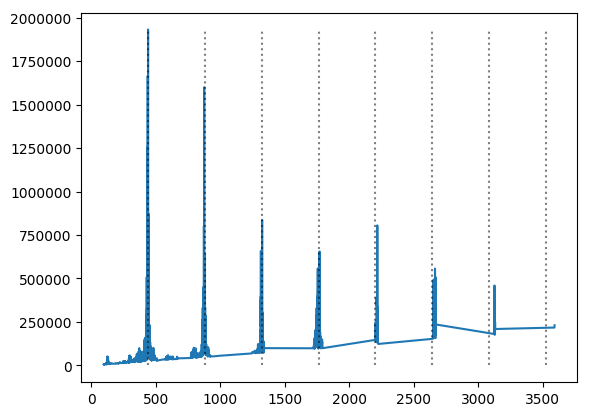

Fundamental frequency: 440.3333333333333


In [212]:
plot(maxfreqs, maxfreqs.*norms[maxinds])

maxval, maxind = findmax(maxfreqs.*norms[maxinds])
for i in 1:8
    plot(i*maxfreqs[maxind]*ones(2), [0, maxval], ":k", alpha=0.5)
end
println("Fundamental frequency: $(maxfreqs[maxind])")